In [3]:
%pylab inline
lecture = 11

import sys
sys.path.append("lib")
import fmt
import sympy as sp
import pandas as pd
from IPython.display import display

assert sp.__version__ == "0.7.5", "Need sympy version 0.7.5 to render properly"
sp.init_printing(use_latex = True)

Populating the interactive namespace from numpy and matplotlib


# Lecture 11: Numerical Methods for Ordinary Differential Equations

## Objectives

* Basic theory on ODE
    * Picard's Theorem
    
    
* A Couple of Examples in Finance
    * Black-Scholes Equation
    * Affine Term-structure model
    
    




* Basic Numerical Methods for ODEs
    * Forward Euler
    * Backward Euler
    * Crank-Nicholson Method
    
    
* Consistency, Stability and Convergence

* Concepts of Stiffness and Stability Region
    
* The Runge-Kutta and Multistep methods    
    
* Numerical Examples



# Introduction


* The initial value problem (**IVP**) of a general **first** order ordinary differential equation (**ODE**) 

$$
y' = f(t,y), \;\; y(t_0) = y_0
$$

* Its equivalent integral formulation

$$
y(t) = y_0 + \int_{t_0}^t f(s,y(s)) \; ds
$$

* If $f(t,y)$ is independent of $y$, solving the ODE is just a deterministic integration...through appropriate quadrature rules


* If $f(t,y)$ is independent of $t$, the ODE is said to be **autonomous**






* If $y$ and $f$ are vectors, it's a system of first order ODEs

$$
\renewcommand{bs}{\boldsymbol}
\renewcommand{by}{\boldsymbol{y}}
\renewcommand{bf}{\boldsymbol{f}}
\by' = \bf(t, \by), \;\; \by(t_0) = \by_0
$$

* General $n^{th}$ order ODE

$$
y^{(n)}(t) = f(t,y(t),y'(t), \cdots, y^{(n-1)}(t))
$$

* Standard trick to convert a higher(>=2) order ODE into a system of first order ODEs

$$
\bs{z}' = \bs{g}(t, \bs{z})
$$

$\hspace{0.3in}$ where 

$$
\begin{matrix}
\bs{z} =  \left[
\begin{matrix}
y(t) \\
y'(t) \\
\vdots \\
y^{(n-1)}(t) 
\end{matrix}
\right], \;\; \mbox{and} \;\;
\end{matrix}
\begin{matrix}
\bs{g}(t, \bs{z}) =  \left[
\begin{matrix}
y'(t) \\
y''(t) \\
\vdots \\
y^{(n-1)}(t) \\
f(t,y(t),y'(t), \cdots, y^{(n-1)}(t))
\end{matrix}
\right]
\end{matrix}
$$



## Picard's Theorem

* Typical things we want to know after formulating a mathematical problem:

    1) Is there a solution to the problem?

    2) Is the solution unique?

    3) Is the solution **NOT** sensitive to the input/dependent data?

    4) And finally, how to solve for the solution? Analytically? Numerically?


* If answered "yes" to the first three questions, then the problem is **well-posed**


* Otherwise, it's **ill-posed**: try to avoid having to solve an ill-posed problem, if you can't, say a prayer and proceed very cautiously.


* **Picard's theorem**:

    If $f(t,y)$ is uniformly Lipschitz continuous in $y$ in a neighborhood of $(t_0, y(t_0))$, then the IVP of the ODE has a unique solution in the neighborhood.

    There exsits $ K>0 \; \text{s.t.   } \Vert f(t,y_1) - f(t,y_2) \Vert < K \Vert (y_1 - y_2)\Vert$


# ODE Examples in Finance

### **Black-Scholes** equation

$$
C_t = \frac{1}{2}\sigma^2S^2C_{SS} + rSC_S - rC
$$

Define the Laplace transform of option price function $C(t,S)$ by

$$
\renewcommand{hC}{\hat{C}}
\hC(z,\cdot) := \mathcal{L}[C](z) = \int_{0}^{\infty}C(t,\cdot)e^{-zt} \; dt
$$

Taking the Laplace transform of the Black-Scholes equation,

$$
z\hC = \frac{1}{2}\sigma^2S^2 \hC_{SS} + rS \hC_S - r \hC + C_0
$$

Here $C_0$ is the time reversed payoff condition (*).

So one way to solve the Black-Scholes eqn is to solve the above ODE and then apply the inverse Laplace Transform.




### Affine Term Structure model

Assume the short rate is affine under the risk-neutral measure

$$
dr_t = \kappa(\theta-r_t)dt + \sqrt{\sigma_1 +\sigma_2 r_t}\;dW_t
$$

Then bond prices are solution to the PDE:

$$
\frac{1}{2}P_{rr}(\sigma_1 +\sigma_2 r) + P_r\kappa(\theta - r)+ P_t -rP = 0
$$

with $P(T,T) = 1$. Looking for solution in the form 

$$
P(r,t,T) = e^{A(T-t) - B(T-t)r},
$$

we find that $A(\cdot), B(\cdot)$ satisfy the following system of ODEs (known as **Ricatti** equations)

\begin{aligned}
-B' & = \frac{1}{2}\sigma_2B^2 + \kappa B - 1
\\
 A' & = \frac{1}{2}\sigma_1B^2 - \kappa \theta B
\end{aligned}
with $A(0) = B(0) = 0$.



# Numerical Methods 

* Will focus on **Finite Difference Methods**(FDM) here.


* Other methods for ODE/PDEs: Finite element methods, Spectral Methods, etc.


* All methods for IVP of ODE are recursions that update $y^{n+1}$ from previous $y^n$ together with evaluating the function $f(t, y)$ a few times around $t^n$.


* The only differentiating part is how the updating is done.




## Finite Difference Methods(FDM)

Employing finite difference method typically means:

1) Generate a grid of points where we want to find the solutions

2) Substitute the derivatives in ODE/PDE with finite difference schemes, which converts the ODE/PDE into a system of algebraic equations.

3) Solve the system of algebraic equations.

4) Implement and debug the computer code.

5) Perform sanity check, error analysis, sensitity analysis, etc, by any available means: intuitively, analytically or numerically.





## The (Forward) Euler's Method 

* Approximate the first derivative by the forward difference formula

$$
\mathcal{D}_+y(t) = \frac{y(t+h)-y(t)}{h}  = y'(t) + O(h)
$$

* The one step (Forward) Euler's method:

$$
\frac{y^{n+1} - y^n}{h}  = f(t^n, y^n);
$$

* or

$$
y^{n+1} = y^n  + h f(t^n, y^n).
$$

* The method is **explicit**, we do not need to solve any equations.


## The Backward Euler's Method 

* Evaluating the RHS at $(t^{n+1}, y^{n+1})$ one obtains the one step backward Euler's method:

$$
\frac{y^{n+1} - y^n}{h}  = f(t^{n+1}, y^{n+1})\; \Longrightarrow \;
y^{n+1} = y^n  + h f(t^{n+1}, y^{n+1}).
$$

* The method is **implicit**: if $f(t,y)$ is nonlinear, we would have to solve a nonlinear equation to get $y^{n+1}$.



## The Crank-Nicholson Method 

* Taking the average of the two RHS above, we get the Crank-Nicholson (also called Trapezoidal) method:

$$
\frac{y^{n+1} - y^n}{h}  = \frac{1}{2}\left( f(t^n, y^n) + f(t^{n+1}, y^{n+1}) \right)\; \Longrightarrow \;
y^{n+1} = y^n  + \frac{h}{2}\left( f(t^n, y^n) + f(t^{n+1}, y^{n+1}) \right).
$$


* The three methods above can also be obtained easily from the integral formulation

$$
y^{n+1} = y^n + \int_{t^n}^{t^{n+1}} f(s,y(s)) \; ds
$$

 *  by taking the left hand rule (Euler), right hand rule (Backward Euler) and average (Trapezoidal).

## Consistency, Stability and Convergence

* For any FDM that are employed to solve practical problems, we should ask

    1) How accurate is the method?
    
    2) Does it converge?
    
    3) What is the best choice of step size?




### Local Truncation Error 

* Defined as the amount by which the exact solution does not satisfy the numerical scheme.


* Just plug the exact values of the functions/variables into the FDM scheme and calculate the error, for Euler scheme, this is,


\begin{aligned}
\mathcal{N}_h y(t^n) & = y(t^{n+1}) - y(t^n)  - h f(t^n, y(t^n))
\\
    & = y(t^{n}+h) - y(t^n)  - h f(t^n, y(t^n))
\\
    & = \left( y(t^n) + hy'(t^n) + \frac{h^2}{2}y''(t^n)+ \cdots \right) - y(t^n)  - h f(t^n, y(t^n))
\\
    & = \frac{h^2}{2}y''(t^n) + O(h^3).
\end{aligned}

* At the last step, we used the exact ODE: $y'(t^n) = f(t^n, y(t^n))$.




### Consistency 

* An FDM is **consistent** if the local truncation error goes to 0 as the step size goes to 0.


* An FDM is **consistent with order $q>1$** if $|\mathcal{N}_h y(t^n) | = O(h^q)$.


* The Euler method is consistent with the second order.




### "Consistently Insufficient"

* Turns out being consistent is not enough.


* Consider the simple ODE
$$
y'(t) = \lambda y(t), \; y(0) = 1.0, \; \lambda < 0.
$$


* Applying the Euler's method, gives:

$$
y^{n+1} = y^n + \lambda y^n h = ( 1 + \lambda h) y^n = ( 1 + \lambda h)^2 y^{n-1} = \cdots \bs{\leadsto}
$$
$$
y^n =  ( 1 + \lambda h)^n 
$$


* The solution will explode if $|1+\lambda h| > 1$. For example, when $\lambda = -10$ and $h = 0.25$.


* While the exact solution of the problem is $y(t) = e^{\lambda t}$, which decays exponentially with $\lambda <0$.


* The problem is with error propagation of the FDM, we need more...


### Stability

* What's missing is: **Zero-stability**


* A method is called **zero-stable ** if there are constants $h_0$ and $K$ so for any mesh functions $y_h$ and $z_h$ on an interval $[0,T]$ with $h \leq h_0$,

$$
|y^n - z^n| \leq K\left\{ |y^0 - z^0| + \max_{1 \leq j \leq N} | \mathcal{N}_h y(t^j) - \mathcal{N}_h z(t^j) | \right\}
$$
for $1 \leq n \leq N$. $y^0$ and $z^0$ are different initial values for $y$ and we wanna see if different initial values would lead to growing errors with the same step size.


* Zero-stability essentially says **local** errors (e.g. roundoff erros, function evaluation errors) introduced in any step do **NOT** get magnified in the recursion process.



### Consistency + Stability = convergence

* An FDM  is said to be **convergent with order $p > 0$ **, or to have the order of accuracy $p$, if for any finite $T$ for which the ODE has  a solution,

$$
|y^n  - y(t^n)| = O(h^p), \;\; \forall 0 \leq n \leq T/h.
$$


* A central theorem in numerical method for differential equations is the **Lax equivalence theorem**:  Any consistent method is convergent if and only if it is zero-stable or

$$
\mbox{consistency + stability = convergence}
$$


* For the Euler method, the stability can be satisfied if the time step satisfies the **stability criterion**

$$
|1+\lambda h| \leq 1 \Longrightarrow  0 < h < -\frac{2}{\lambda }.
$$


* This condition is often referred to as the **CFL (Courant-Friedrichsâ€“Lewy)** condition.



### Absolute Stability

* The (Forward) Euler's method is said to be **conditionally stable**.


* Its **region of absolute stability** is defined as the set of complex numbers $z = \lambda h$, such that the FDM solution decays to 0, that is

$$
|1+\lambda h| = |1+z| = |z - (-1)| \leq 1,
$$

amounts to a unit disk with radius 1 and center $(-1,0)$.


* An FDM is called **A-Stable** or **unconditionally stable** if its region of absolute stability is the entire negative left half plane, i.e. $\Re{z} < 0$.



## The backward Euler's Method 

* The method is **implicit**: if $f(t,y)$ is nonlinear, we would have to solve a nonlinear equation to get $y^{n+1}$.

* For the Backward Eulers method: the local truncation error is

\begin{aligned}
\mathcal{N}_h y(t^n) & = y(t^{n+1}) - y(t^n)  - h f(t^{n+1}, y(t^{n+1}))
\\
    & = y(t^{n+1}) - y(t^{n+1}-h)  - h f(t^{n+1}, y(t^{n+1}))
\\
    & = -\frac{h^2}{2}y''(t^{n+1}) + O(h^3).
\end{aligned}

* Set $f(t,y) = \lambda y$, then 

$$
y^{n+1} = y^n + h\lambda y^{n+1}, \Longrightarrow y^{n+1} =\frac{1}{1-h\lambda}y^n
$$

* The CFL condition is $\frac{1}{1-h\lambda} \leq 1$, which is always satisfied with $h > 0, \lambda < 0$, so it is A-Stable.

## The Crank-Nicholson Method 


* For the Crank-Nicholson method, the local truncation error is

\begin{aligned}
\mathcal{N}_h y(t^n) & = y(t^{n+1}) - y(t^n)  - \frac{h}{2}\left( f(t^n, y^n) + f(t^{n+1}, y^{n+1}) \right).
\\
    & = -\frac{h^3}{6}y'''(t^{n+1/2}) + O(h^4).
\end{aligned}

* Set $f(t,y) = \lambda y$,

$$
y^{n+1} =\frac{1+h\lambda}{1-h\lambda}y^n
$$


* The CFL condition is $|\frac{1+h\lambda}{1-h\lambda} |\leq 1$, which is always satisfied with $h > 0, \lambda < 0$, so it is also unconditionally stable.

## The Runge-Kutta Method 

* The Crank-Nicholson method is implicit, to make it explicit, we can approximate $y^{n+1}$ in right hand side using the forward Euler's method, and this gets us to the simplest explicit Runge-Kutta method (usually called the Heun's method)

\begin{aligned}
y^* & = y^n  + h f(t^n, y^n)
\\
y^{n+1} & = y^n  + \frac{h}{2}\left( f(t^n, y^n) + f(t^{n+1}, y^*) \right).
\end{aligned}

* The method is second order, but only conditionally stable.

* The is a representative of a powerful class of multi-step methods called **predictor-corrector** methods: the forward Euler as the predictor and the Crank-Nicholson is the corrector.


* The classical Runge-Kutta scheme is the RK4, based on Simpson's integral formula

\begin{aligned}
K_0 & = f(t^n, y^n)
\\
K_1 & = f(t^n + \frac{h}{2}, y^n + \frac{h}{2} K_0)
\\
K_2 & = f(t^n + \frac{h}{2}, y^n + \frac{h}{2} K_1)
\\
K_3 & = f(t^n + h, y^n + hK_2)
\\
y^{n+1} & = y^n  + \frac{h}{6}\left( K_0 + 2K_1 + 2K_2 + K_3 \right).
\end{aligned}

* The method is fourth-order accurate and conditionally stable.


## Stiff ODEs

* ODEs with rapidly decaying transients or with varying time scales often presents huge problems for numerical methods which are not A-Stable.

* Example:
$$
y'(t) = -50[y(t) - t] + 1, \;\; y(0) = 1;
$$


* The solution to the problem can be find exactly: $y(t) = e^{-50t} + t$. It has a slow varying part $t$ and a rapidly decaying part $e^{-50t}$.


* Using the explicit Euler's method requires a time step $h<2/50 = 0.04 << 1$, i.e. many time steps before reaching the reasonable solution.


* In the homework, you will encounter another example, where in a system of first order ODEs, different components of the solution behave in a very different time scales, and the fast changing one dominates the step size in order for the scheme to be stable.


* For stiff ODEs, you either choose really small step size with explicit method (very inefficient!) or choose an A-Stable method (it will cost more in each step).



# Numerical Examples 

* Integrating Van der Pol system using odeint in scipy:





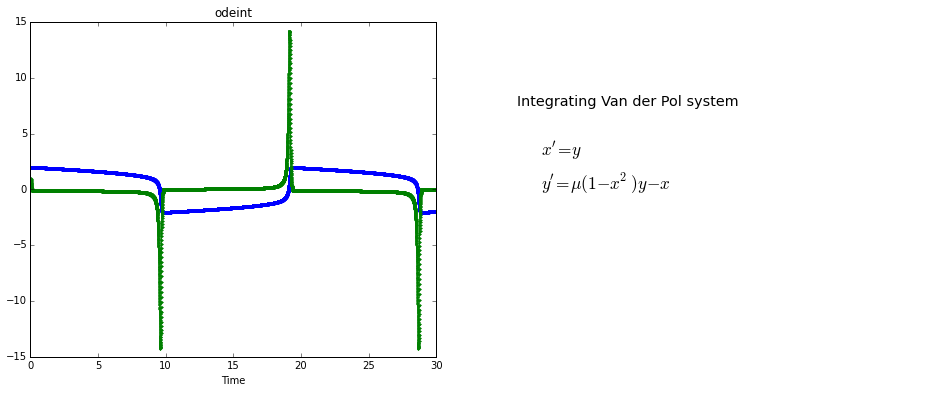

In [33]:
#restart notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

r = 10
def f(y,t):
    return [y[1], r*(1 - y[0]*y[0])*y[1] - y[0]]

# initial value
y0 = [2.0, 1.]

n = 10000
T = 3.0*r
h = T/n
# print h
ts = np.arange(0.0001,T, h)
ys = odeint(f, y0, ts)
   
fig = plt.figure(figsize=(16,6))
ax =  fig.add_subplot(1, 2, 1)
ax.plot(ts, ys[:, :], '.-')  
plt.xlabel('Time')
plt.title('odeint')

ax = fig.add_subplot(122)
ax.set_axis_off()
ax.text(0, .5, "$\;\; y' = \mu (1-x^2)y - x$ ", size="xx-large");
ax.text(0, .6, "$\;\; x' = y$", size="xx-large");
ax.text(0, .75, "Integrating Van der Pol system", size="x-large");

plt.show()




* Integrating lorenz system using ode(*) in scipy:







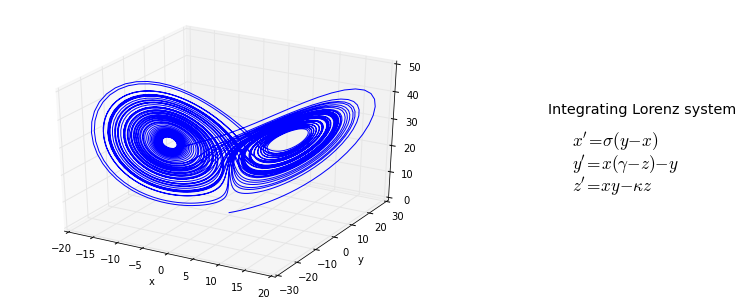

In [35]:
from scipy.integrate import ode
from mpl_toolkits.mplot3d import Axes3D

def lorenz_sys(t, q):
    x = q[0]
    y = q[1]
    z = q[2]
    # sigma, rho and beta are global.
    f = [sigma * (y - x),
         rho*x - y - x*z,
         x*y - beta*z]
    return f


#ic = [1.0, 2.0, 1.0]
ic = [0.01, 0.01, 0.01]
t0 = 0.0
t1 = 70.0
dt = 0.01

sigma = 10.0
rho = 28.0
beta = 8.0/3.0

#sigma = 28.0
#rho = 46.92
#beta = 4.0

solver = ode(lorenz_sys)

t = []
sol = []
solver.set_initial_value(ic, t0)
#solver.set_integrator('dop853')
solver.set_integrator('dopri5')

while solver.successful() and solver.t < t1:
    solver.integrate(solver.t + dt)
    t.append(solver.t)
    sol.append(solver.y)

t = np.array(t)
sol = np.array(sol)


fig = plt.figure()
ax = Axes3D(fig)
ax.plot(sol[:,0], sol[:,1], sol[:,2])
plt.xlabel('x')
plt.ylabel('y')

ax = fig.add_subplot(122)
ax.set_axis_off()
ax.text(2, .3, "$\;\; z' = x y -\kappa z$", size="xx-large");
ax.text(2, .4, "$\;\; y' = x ( \gamma - z ) - y $", size="xx-large");
ax.text(2, .5, "$\;\; x' = \sigma (y - x) $", size="xx-large");
ax.text(2, .65, "Integrating Lorenz system", size="x-large");

plt.show()
